In [1]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

from datasets.SP100Stocks import SP100Stocks
from notebooks.models import A3TGCN, train, get_regression_error, plot_regression

# Stock prices forecasting
The goal of this task is to predict the (normalized) price at the timestep $t+1$ for each stock in the S&P 100 index. For this task, we use the previously introduced Spatio-Temporal Graph Neural Networks.

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [2]:
seq_len = 25
dataset = SP100Stocks(past_window=seq_len)
dataset, dataset[0]

(SP100Stocks(1209),
 Data(x=[100, 5, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

In [3]:
train_part = .9
batch_size = 32

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 1088, Test dataset: 121


## Training
The previously implemented models are used, trained using the training dataset and the Adam optimizer. The `weight_decay` parameter is used for L2 regularization, to follow the T-GCN papers methodology. The loss is calculated using the Mean Squared Error (MSE) loss function.

In [10]:
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb)

lr, weight_decay, num_epochs = 0.005, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

A3TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(5, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=37, out_features=16, bias=True)
      (lin_r): Linear(in_features=37, out_features=16, bias=True)
      (lin_c): Linear(in_features=37, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Softmax(dim=1)
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [11]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting")

Epochs: 100%|██████████| 16/16 [14:33<00:00, 54.62s/it, Batch=100.0%]


## Results
The model tries to forecast the variations one timestep ahead for four stocks. The real values are plotted against the forecasted values.

### Results on train data

In [12]:
mse, rmse, mae, mre = get_regression_error(model, train_dataloader)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Train MSE: 0.0123, RMSE: 0.1099, MAE: 0.0789, MRE: 0.1018


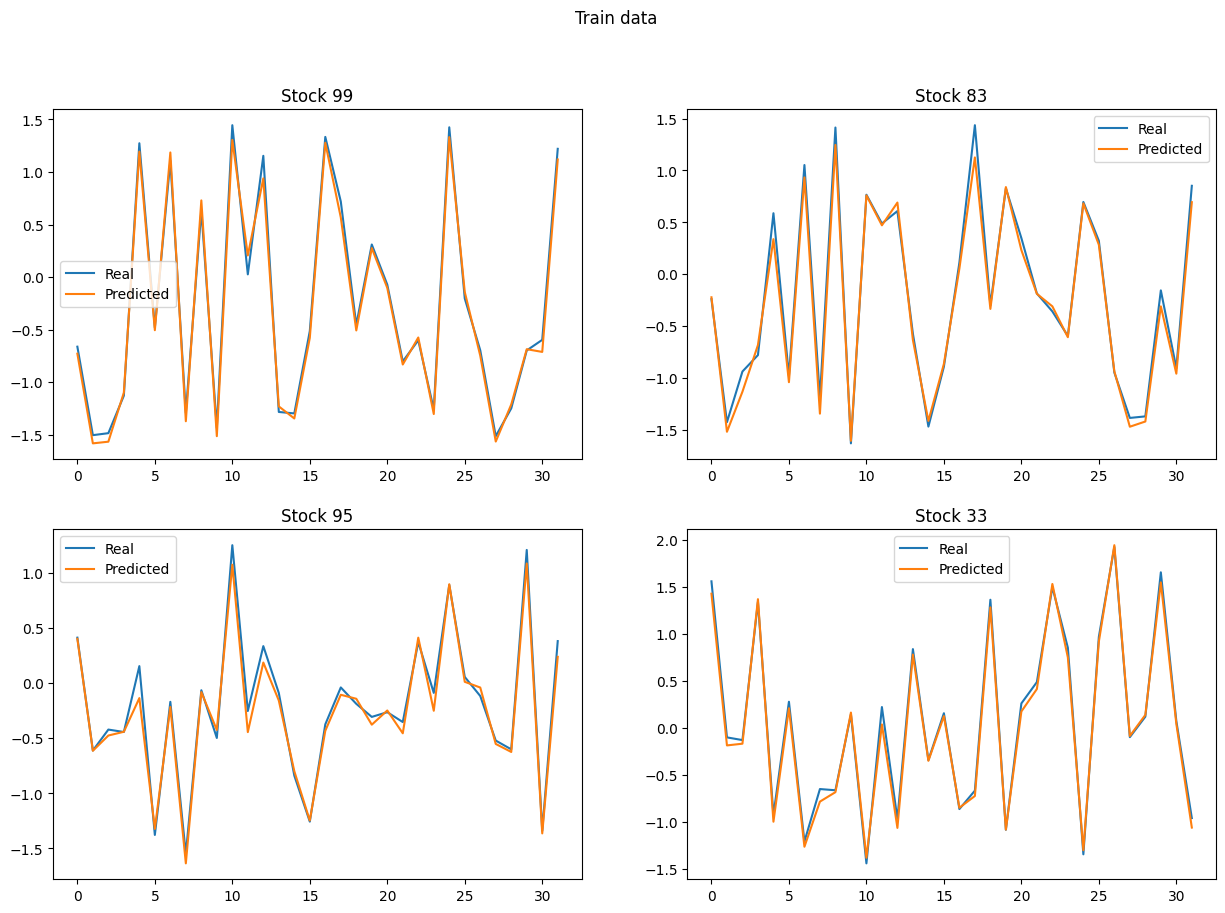

In [13]:
plot_regression(model, next(iter(train_dataloader)), "Train data")

### Results on test data

In [14]:
mse, rmse, mae, mre = get_regression_error(model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 0.0232, RMSE: 0.1523, MAE: 0.1022, MRE: 0.0880


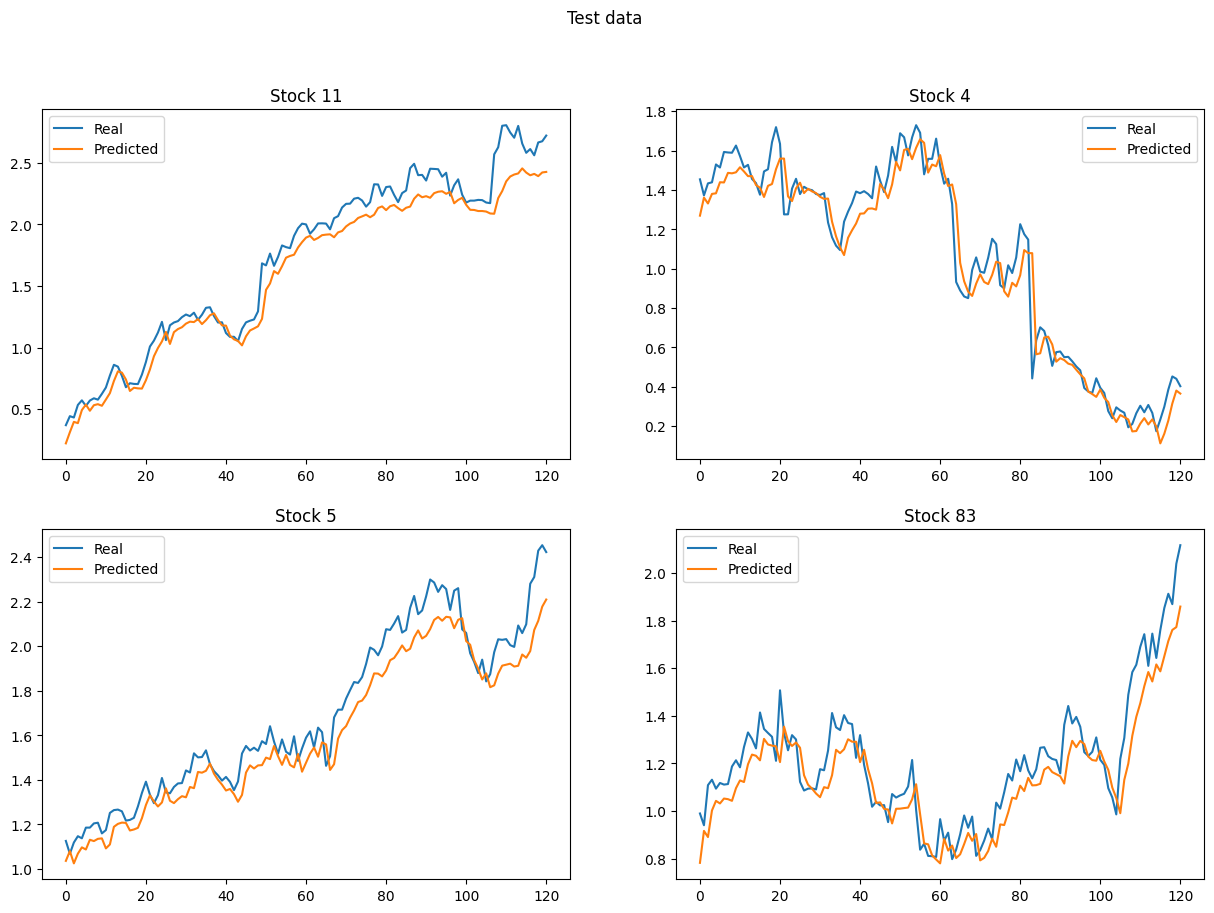

In [15]:
plot_regression(model, next(iter(test_dataloader)), "Test data")